In [0]:
!rm -rf images/
!git clone --single-branch --branch work_one https://github.com/romellfudi/dataset_currency.git
!mv dataset_currency/* .
!rm -rf dataset_currency/

Cloning into 'dataset_currency'...
remote: Enumerating objects: 214, done.
remote: Counting objects: 100% (214/214), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 934 (delta 199), reused 208 (delta 199), pack-reused 720
Receiving objects: 100% (934/934), 64.81 MiB | 24.56 MiB/s, done.
Resolving deltas: 100% (447/447), done.


In [0]:
!git clone https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 30732 (delta 6), reused 12 (delta 2), pack-reused 30694
Receiving objects: 100% (30732/30732), 510.61 MiB | 34.24 MiB/s, done.
Resolving deltas: 100% (19298/19298), done.
Checking out files: 100% (3079/3079), done.


In [0]:
!cd models/research/;protoc --python_out=. ./object_detection/protos/anchor_generator.proto ./object_detection/protos/argmax_matcher.proto ./object_detection/protos/bipartite_matcher.proto ./object_detection/protos/box_coder.proto ./object_detection/protos/box_predictor.proto ./object_detection/protos/eval.proto ./object_detection/protos/faster_rcnn.proto ./object_detection/protos/faster_rcnn_box_coder.proto ./object_detection/protos/grid_anchor_generator.proto ./object_detection/protos/hyperparams.proto ./object_detection/protos/image_resizer.proto ./object_detection/protos/input_reader.proto ./object_detection/protos/losses.proto ./object_detection/protos/matcher.proto ./object_detection/protos/mean_stddev_box_coder.proto ./object_detection/protos/model.proto ./object_detection/protos/optimizer.proto ./object_detection/protos/pipeline.proto ./object_detection/protos/post_processing.proto ./object_detection/protos/preprocessor.proto ./object_detection/protos/region_similarity_calculator.proto ./object_detection/protos/square_box_coder.proto ./object_detection/protos/ssd.proto ./object_detection/protos/ssd_anchor_generator.proto ./object_detection/protos/string_int_label_map.proto ./object_detection/protos/train.proto ./object_detection/protos/keypoint_box_coder.proto ./object_detection/protos/multiscale_anchor_generator.proto ./object_detection/protos/graph_rewriter.proto ./object_detection/protos/calibration.proto ./object_detection/protos/flexible_grid_anchor_generator.proto

In [0]:
!python models/research/setup.py build
!python models/research/setup.py install

running build
running install
running bdist_egg
running egg_info
creating object_detection.egg-info
writing object_detection.egg-info/PKG-INFO
writing dependency_links to object_detection.egg-info/dependency_links.txt
writing requirements to object_detection.egg-info/requires.txt
writing top-level names to object_detection.egg-info/top_level.txt
writing manifest file 'object_detection.egg-info/SOURCES.txt'
reading manifest file 'object_detection.egg-info/SOURCES.txt'
writing manifest file 'object_detection.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib

creating build
creating build/bdist.linux-x86_64
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/EGG-INFO
copying object_detection.egg-info/PKG-INFO -> build/bdist.linux-x86_64/egg/EGG-INFO
copying object_detection.egg-info/SOURCES.txt -> build/bdist.linux-x86_64/egg/EGG-INFO
copying object_detection.egg-info/dependency_links.txt -> build/bdist.linux-x86_64/e

# Notebook

In [0]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("models/research/")
from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.12.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.12.*.')

In [0]:
# This is needed to display the images.
%matplotlib inline

In [0]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [0]:
# What model to download.
MODEL_NAME = 'ssd_mobilenet_v1_coco_2017_11_17'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('models/research/object_detection','data', 'mscoco_label_map.pbtxt')

In [0]:
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())


In [0]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [0]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [0]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Continue

In [0]:
%%writefile xml_to_csv.py
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET


def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(member[4][0].text),
                     int(member[4][1].text),
                     int(member[4][2].text),
                     int(member[4][3].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df


def main():
    for folder in ['train','test']:
        image_path = os.path.join(os.getcwd(), ('images/' + folder))
        xml_df = xml_to_csv(image_path)
        xml_df.to_csv(('images/' + folder + '_labels.csv'), index=None)
        print('Successfully converted xml to csv.')


main()

Overwriting xml_to_csv.py


In [0]:
%%writefile generate_tfrecord.py
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import

import os
import io
import pandas as pd
import tensorflow as tf

from PIL import Image
from models.research.object_detection.utils import dataset_util
from collections import namedtuple, OrderedDict

flags = tf.app.flags
flags.DEFINE_string('csv_input', '', 'Path to the CSV input')
flags.DEFINE_string('image_dir', '', 'Path to the image directory')
flags.DEFINE_string('output_path', '', 'Path to output TFRecord')
FLAGS = flags.FLAGS


# TO-DO replace this with label map
def class_text_to_int(row_label):
    if row_label == 'B10':
        return 1
    elif row_label == 'B20':
        return 2
    elif row_label == 'B50':
        return 3
    elif row_label == 'B100':
        return 4
    else:
        None


def split(df, group):
    data = namedtuple('data', ['filename', 'object'])
    gb = df.groupby(group)
    return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]


def create_tf_example(group, path):
    with tf.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
        encoded_jpg = fid.read()
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = Image.open(encoded_jpg_io)
    width, height = image.size

    filename = group.filename.encode('utf8')
    image_format = b'jpg'
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    classes_text = []
    classes = []

    for index, row in group.object.iterrows():
        xmins.append(row['xmin'] / width)
        xmaxs.append(row['xmax'] / width)
        ymins.append(row['ymin'] / height)
        ymaxs.append(row['ymax'] / height)
        classes_text.append(row['class'].encode('utf8'))
        classes.append(class_text_to_int(row['class']))

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example


def main(_):
    writer = tf.python_io.TFRecordWriter(FLAGS.output_path)
    path = os.path.join(os.getcwd(), FLAGS.image_dir)
    examples = pd.read_csv(FLAGS.csv_input)
    grouped = split(examples, 'filename')
    for group in grouped:
        tf_example = create_tf_example(group, path)
        writer.write(tf_example.SerializeToString())

    writer.close()
    output_path = os.path.join(os.getcwd(), FLAGS.output_path)
    print('Successfully created the TFRecords: {}'.format(output_path))


if __name__ == '__main__':
    tf.app.run()


Overwriting generate_tfrecord.py


In [0]:
# !python xml_to_csv.py

Successfully converted xml to csv.
Successfully converted xml to csv.


In [0]:
# # !rm -rf images/test/P8120001.JPG
# !mv train_labels.csv images/
# !mv test_labels.csv images/

In [0]:
!python generate_tfrecord.py --csv_input=images/train_labels.csv --image_dir=images/train --output_path=train.record
!python generate_tfrecord.py --csv_input=images/test_labels.csv --image_dir=images/test --output_path=test.record



W0918 11:22:12.893163 139789119080320 deprecation_wrapper.py:119] From generate_tfrecord.py:83: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W0918 11:22:13.066510 139789119080320 deprecation_wrapper.py:119] From generate_tfrecord.py:42: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

Successfully created the TFRecords: /content/train.record


W0918 11:22:17.694495 140442666735488 deprecation_wrapper.py:119] From generate_tfrecord.py:83: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W0918 11:22:17.731993 140442666735488 deprecation_wrapper.py:119] From generate_tfrecord.py:42: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

Successfully created the TFRecords: /content/test.record


In [0]:
!cp models/research/object_detection/legacy/train.py models/research/object_detection/

In [0]:
!wget http://download.tensorflow.org/models/object_detection/faster_rcnn_inception_v2_coco_2018_01_28.tar.gz

--2019-09-18 11:22:29--  http://download.tensorflow.org/models/object_detection/faster_rcnn_inception_v2_coco_2018_01_28.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 64.233.167.128, 2a00:1450:400c:c07::80
Connecting to download.tensorflow.org (download.tensorflow.org)|64.233.167.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149119618 (142M) [application/x-tar]
Saving to: ‘faster_rcnn_inception_v2_coco_2018_01_28.tar.gz’

faster_rcnn_incepti 100%[===================>] 142.21M  60.2MB/s    in 2.4s    

2019-09-18 11:22:32 (60.2 MB/s) - ‘faster_rcnn_inception_v2_coco_2018_01_28.tar.gz’ saved [149119618/149119618]



In [0]:
!tar -xvzf faster_rcnn_inception_v2_coco_2018_01_28.tar.gz

faster_rcnn_inception_v2_coco_2018_01_28/
faster_rcnn_inception_v2_coco_2018_01_28/model.ckpt.index
faster_rcnn_inception_v2_coco_2018_01_28/checkpoint
faster_rcnn_inception_v2_coco_2018_01_28/pipeline.config
faster_rcnn_inception_v2_coco_2018_01_28/model.ckpt.data-00000-of-00001
faster_rcnn_inception_v2_coco_2018_01_28/model.ckpt.meta
faster_rcnn_inception_v2_coco_2018_01_28/saved_model/
faster_rcnn_inception_v2_coco_2018_01_28/saved_model/saved_model.pb
faster_rcnn_inception_v2_coco_2018_01_28/saved_model/variables/
faster_rcnn_inception_v2_coco_2018_01_28/frozen_inference_graph.pb


In [0]:
!rm -rf training/
!mkdir training/

In [0]:
%%writefile training/faster_rcnn_inception_v2_pets.config
model {
  faster_rcnn {
    num_classes: 4
    image_resizer {
      keep_aspect_ratio_resizer {
        min_dimension: 600
        max_dimension: 1024
      }
    }
    feature_extractor {
      type: 'faster_rcnn_inception_v2'
      first_stage_features_stride: 16
    }
    first_stage_anchor_generator {
      grid_anchor_generator {
        scales: [0.25, 0.5, 1.0, 2.0]
        aspect_ratios: [0.5, 1.0, 2.0]
        height_stride: 16
        width_stride: 16
      }
    }
    first_stage_box_predictor_conv_hyperparams {
      op: CONV
      regularizer {
        l2_regularizer {
          weight: 0.0
        }
      }
      initializer {
        truncated_normal_initializer {
          stddev: 0.01
        }
      }
    }
    first_stage_nms_score_threshold: 0.0
    first_stage_nms_iou_threshold: 0.7
    first_stage_max_proposals: 300
    first_stage_localization_loss_weight: 2.0
    first_stage_objectness_loss_weight: 1.0
    initial_crop_size: 14
    maxpool_kernel_size: 2
    maxpool_stride: 2
    second_stage_box_predictor {
      mask_rcnn_box_predictor {
        use_dropout: false
        dropout_keep_probability: 1.0
        fc_hyperparams {
          op: FC
          regularizer {
            l2_regularizer {
              weight: 0.0
            }
          }
          initializer {
            variance_scaling_initializer {
              factor: 1.0
              uniform: true
              mode: FAN_AVG
            }
          }
        }
      }
    }
    second_stage_post_processing {
      batch_non_max_suppression {
        score_threshold: 0.0
        iou_threshold: 0.6
        max_detections_per_class: 100
        max_total_detections: 300
      }
      score_converter: SOFTMAX
    }
    second_stage_localization_loss_weight: 2.0
    second_stage_classification_loss_weight: 1.0
  }
}

train_config: {
  batch_size: 1
  optimizer {
    momentum_optimizer: {
      learning_rate: {
        manual_step_learning_rate {
          initial_learning_rate: 0.0002
          schedule {
            step: 1
            learning_rate: .0002
          }
          schedule {
            step: 900000
            learning_rate: .00002
          }
          schedule {
            step: 1200000
            learning_rate: .000002
          }
        }
      }
      momentum_optimizer_value: 0.9
    }
    use_moving_average: false
  }
  gradient_clipping_by_norm: 10.0
  fine_tune_checkpoint: "faster_rcnn_inception_v2_coco_2018_01_28/model.ckpt"
  from_detection_checkpoint: true
  load_all_detection_checkpoint_vars: true
  # Note: The below line limits the training process to 200K steps, which we
  # empirically found to be sufficient enough to train the pets dataset. This
  # effectively bypasses the learning rate schedule (the learning rate will
  # never decay). Remove the below line to train indefinitely.
  num_steps: 200000
  data_augmentation_options {
    random_horizontal_flip {
    }
  }
}


train_input_reader: {
  tf_record_input_reader {
    input_path: "train.record"
  }
  label_map_path: "training/labelmap.pbtxt"
}

eval_config: {
  metrics_set: "coco_detection_metrics"
  num_examples: 164
}

eval_input_reader: {
  tf_record_input_reader {
    input_path: "test.record"
  }
  label_map_path: "training/labelmap.pbtxt"
  shuffle: false
  num_readers: 1
}


Writing training/faster_rcnn_inception_v2_pets.config


In [0]:
%%writefile  training/labelmap.pbtxt
item {
  id: 1
  name: 'B10'
}

item {
  id: 2
  name: 'B20'
}

item {
  id: 3
  name: 'B50'
}

item {
  id: 4
  name: 'B100'
}


Writing training/labelmap.pbtxt


In [0]:
%%writefile  models/research/object_detection/train.py
import functools
import json
import os
import tensorflow as tf
import sys
sys.path.append("models/research/")
sys.path.append("models/research/slim/")

from object_detection.builders import dataset_builder
from object_detection.builders import graph_rewriter_builder
from object_detection.builders import model_builder
from object_detection.legacy import trainer
from object_detection.utils import config_util

tf.logging.set_verbosity(tf.logging.INFO)

flags = tf.app.flags
flags.DEFINE_string('master', '', 'Name of the TensorFlow master to use.')
flags.DEFINE_integer('task', 0, 'task id')
flags.DEFINE_integer('num_clones', 1, 'Number of clones to deploy per worker.')
flags.DEFINE_boolean('clone_on_cpu', False,
                     'Force clones to be deployed on CPU.  Note that even if '
                     'set to False (allowing ops to run on gpu), some ops may '
                     'still be run on the CPU if they have no GPU kernel.')
flags.DEFINE_integer('worker_replicas', 1, 'Number of worker+trainer '
                     'replicas.')
flags.DEFINE_integer('ps_tasks', 0,
                     'Number of parameter server tasks. If None, does not use '
                     'a parameter server.')
flags.DEFINE_string('train_dir', '',
                    'Directory to save the checkpoints and training summaries.')

flags.DEFINE_string('pipeline_config_path', '',
                    'Path to a pipeline_pb2.TrainEvalPipelineConfig config '
                    'file. If provided, other configs are ignored')

flags.DEFINE_string('train_config_path', '',
                    'Path to a train_pb2.TrainConfig config file.')
flags.DEFINE_string('input_config_path', '',
                    'Path to an input_reader_pb2.InputReader config file.')
flags.DEFINE_string('model_config_path', '',
                    'Path to a model_pb2.DetectionModel config file.')

FLAGS = flags.FLAGS


@tf.contrib.framework.deprecated(None, 'Use object_detection/model_main.py.')
def main(_):
  assert FLAGS.train_dir, '`train_dir` is missing.'
  if FLAGS.task == 0: tf.gfile.MakeDirs(FLAGS.train_dir)
  if FLAGS.pipeline_config_path:
    configs = config_util.get_configs_from_pipeline_file(
        FLAGS.pipeline_config_path)
    if FLAGS.task == 0:
      tf.gfile.Copy(FLAGS.pipeline_config_path,
                    os.path.join(FLAGS.train_dir, 'pipeline.config'),
                    overwrite=True)
  else:
    configs = config_util.get_configs_from_multiple_files(
        model_config_path=FLAGS.model_config_path,
        train_config_path=FLAGS.train_config_path,
        train_input_config_path=FLAGS.input_config_path)
    if FLAGS.task == 0:
      for name, config in [('model.config', FLAGS.model_config_path),
                           ('train.config', FLAGS.train_config_path),
                           ('input.config', FLAGS.input_config_path)]:
        tf.gfile.Copy(config, os.path.join(FLAGS.train_dir, name),
                      overwrite=True)

  model_config = configs['model']
  train_config = configs['train_config']
  input_config = configs['train_input_config']

  model_fn = functools.partial(
      model_builder.build,
      model_config=model_config,
      is_training=True)

  def get_next(config):
    return dataset_builder.make_initializable_iterator(
        dataset_builder.build(config)).get_next()

  create_input_dict_fn = functools.partial(get_next, input_config)

  env = json.loads(os.environ.get('TF_CONFIG', '{}'))
  cluster_data = env.get('cluster', None)
  cluster = tf.train.ClusterSpec(cluster_data) if cluster_data else None
  task_data = env.get('task', None) or {'type': 'master', 'index': 0}
  task_info = type('TaskSpec', (object,), task_data)

  # Parameters for a single worker.
  ps_tasks = 0
  worker_replicas = 1
  worker_job_name = 'lonely_worker'
  task = 0
  is_chief = True
  master = ''

  if cluster_data and 'worker' in cluster_data:
    # Number of total worker replicas include "worker"s and the "master".
    worker_replicas = len(cluster_data['worker']) + 1
  if cluster_data and 'ps' in cluster_data:
    ps_tasks = len(cluster_data['ps'])

  if worker_replicas > 1 and ps_tasks < 1:
    raise ValueError('At least 1 ps task is needed for distributed training.')

  if worker_replicas >= 1 and ps_tasks > 0:
    # Set up distributed training.
    server = tf.train.Server(tf.train.ClusterSpec(cluster), protocol='grpc',
                             job_name=task_info.type,
                             task_index=task_info.index)
    if task_info.type == 'ps':
      server.join()
      return

    worker_job_name = '%s/task:%d' % (task_info.type, task_info.index)
    task = task_info.index
    is_chief = (task_info.type == 'master')
    master = server.target

  graph_rewriter_fn = None
  if 'graph_rewriter_config' in configs:
    graph_rewriter_fn = graph_rewriter_builder.build(
        configs['graph_rewriter_config'], is_training=True)

  trainer.train(
      create_input_dict_fn,
      model_fn,
      train_config,
      master,
      task,
      FLAGS.num_clones,
      worker_replicas,
      FLAGS.clone_on_cpu,
      ps_tasks,
      worker_job_name,
      is_chief,
      FLAGS.train_dir,
      graph_hook_fn=graph_rewriter_fn)


if __name__ == '__main__':
  tf.app.run()


Overwriting models/research/object_detection/train.py


In [0]:
%%writefile export_inference_graph.py
import tensorflow as tf
from google.protobuf import text_format
import sys
sys.path.append("models/research/")
sys.path.append("models/research/slim/")
from object_detection import exporter
from object_detection.protos import pipeline_pb2

slim = tf.contrib.slim
flags = tf.app.flags

flags.DEFINE_string('input_type', 'image_tensor', 'Type of input node. Can be '
                    'one of [`image_tensor`, `encoded_image_string_tensor`, '
                    '`tf_example`]')
flags.DEFINE_string('input_shape', None,
                    'If input_type is `image_tensor`, this can explicitly set '
                    'the shape of this input tensor to a fixed size. The '
                    'dimensions are to be provided as a comma-separated list '
                    'of integers. A value of -1 can be used for unknown '
                    'dimensions. If not specified, for an `image_tensor, the '
                    'default shape will be partially specified as '
                    '`[None, None, None, 3]`.')
flags.DEFINE_string('pipeline_config_path', None,
                    'Path to a pipeline_pb2.TrainEvalPipelineConfig config '
                    'file.')
flags.DEFINE_string('trained_checkpoint_prefix', None,
                    'Path to trained checkpoint, typically of the form '
                    'path/to/model.ckpt')
flags.DEFINE_string('output_directory', None, 'Path to write outputs.')
flags.DEFINE_string('config_override', '',
                    'pipeline_pb2.TrainEvalPipelineConfig '
                    'text proto to override pipeline_config_path.')
flags.DEFINE_boolean('write_inference_graph', False,
                     'If true, writes inference graph to disk.')
tf.app.flags.mark_flag_as_required('pipeline_config_path')
tf.app.flags.mark_flag_as_required('trained_checkpoint_prefix')
tf.app.flags.mark_flag_as_required('output_directory')
FLAGS = flags.FLAGS


def main(_):
  pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
  with tf.gfile.GFile(FLAGS.pipeline_config_path, 'r') as f:
    text_format.Merge(f.read(), pipeline_config)
  text_format.Merge(FLAGS.config_override, pipeline_config)
  if FLAGS.input_shape:
    input_shape = [
        int(dim) if dim != '-1' else None
        for dim in FLAGS.input_shape.split(',')
    ]
  else:
    input_shape = None
  exporter.export_inference_graph(
      FLAGS.input_type, pipeline_config, FLAGS.trained_checkpoint_prefix,
      FLAGS.output_directory, input_shape=input_shape,
      write_inference_graph=FLAGS.write_inference_graph)


if __name__ == '__main__':
  tf.app.run()

Overwriting export_inference_graph.py


In [0]:
# # copy files
# !mv checkpoint training/
# !mv pipeline.config training/
# !mv graph.pbtxt training/
# !mv model.ckpt-* training/ 

In [0]:
%%capture
!python models/research/object_detection/train.py --logtostderr --train_dir=training/ --pipeline_config_path=training/faster_rcnn_inception_v2_pets.config

In [0]:
best_model = !ls training/model.ckpt-*.index -1t
best_model = best_model[0][:-6]
best_model

'training/model.ckpt-116400'

In [0]:
%%capture
!rm -rf inference_graph/saved_model/
!rm -rf inference_graph/frozen_inference_graph.pb

!python export_inference_graph.py --input_type image_tensor --pipeline_config_path training/faster_rcnn_inception_v2_pets.config --trained_checkpoint_prefix {best_model} --output_directory inference_graph

/content/inference_graph/frozen_inference_graph.pb
/content/training/labelmap.pbtxt
/content/random/billetes.png


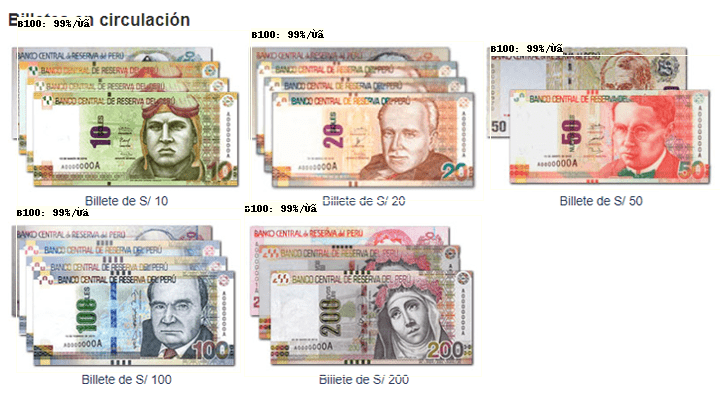

In [0]:
import os
import cv2
import numpy as np
import tensorflow as tf
import sys
sys.path.append("models/research/")

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

# Name of the directory containing the object detection module we're using
MODEL_NAME = 'inference_graph'
IMAGE_NAME = 'random/billetes.png'

# Grab path to current working directory
CWD_PATH = os.getcwd()

# Path to frozen detection graph .pb file, which contains the model that is used
# for object detection.
PATH_TO_CKPT = os.path.join(CWD_PATH,MODEL_NAME,'frozen_inference_graph.pb')
print(PATH_TO_CKPT)
# Path to label map file
PATH_TO_LABELS = os.path.join(CWD_PATH,'training','labelmap.pbtxt')
print(PATH_TO_LABELS)
# Path to image
PATH_TO_IMAGE = os.path.join(CWD_PATH,IMAGE_NAME)
print(PATH_TO_IMAGE)
NUM_CLASSES = 4

label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

    sess = tf.Session(graph=detection_graph)

image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')

num_detections = detection_graph.get_tensor_by_name('num_detections:0')

image = cv2.imread(PATH_TO_IMAGE)
image_expanded = np.expand_dims(image, axis=0)

(boxes, scores, classes, num) = sess.run(
    [detection_boxes, detection_scores, detection_classes, num_detections],
    feed_dict={image_tensor: image_expanded})

vis_util.visualize_boxes_and_labels_on_image_array(
    image,
    np.squeeze(boxes),
    np.squeeze(classes).astype(np.int32),
    np.squeeze(scores),
    category_index,
    use_normalized_coordinates=True,
    line_thickness=1,
    min_score_thresh=0.60)

from google.colab.patches import cv2_imshow
# cv2.imshow('Object detector', image)
cv2_imshow(image)

cv2.waitKey(0)

cv2.destroyAllWindows()

/content/images/train/P8120016.JPG


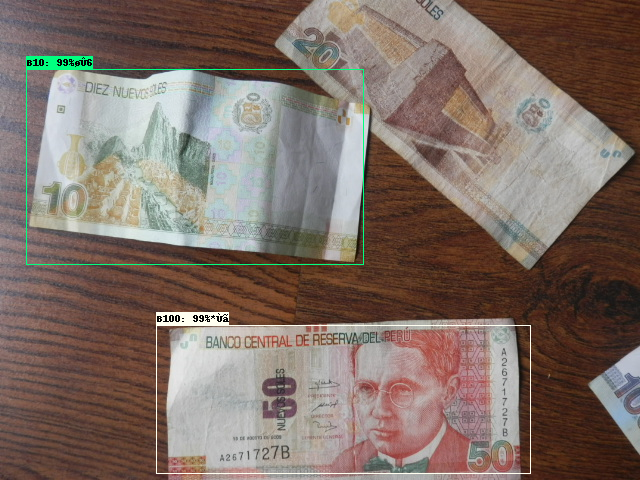

In [0]:
IMAGE_NAME = 'images/train/P8120016.JPG'

PATH_TO_IMAGE = os.path.join(CWD_PATH,IMAGE_NAME)
print(PATH_TO_IMAGE)

image = cv2.imread(PATH_TO_IMAGE)
image_expanded = np.expand_dims(image, axis=0)

(boxes, scores, classes, num) = sess.run(
    [detection_boxes, detection_scores, detection_classes, num_detections],
    feed_dict={image_tensor: image_expanded})

vis_util.visualize_boxes_and_labels_on_image_array(
    image,
    np.squeeze(boxes),
    np.squeeze(classes).astype(np.int32),
    np.squeeze(scores),
    category_index,
    use_normalized_coordinates=True,
    line_thickness=1,
    min_score_thresh=0.65)

from google.colab.patches import cv2_imshow
# cv2.imshow('Object detector', image)
cv2_imshow(image)

cv2.waitKey(0)

cv2.destroyAllWindows()

/content/images/train/P8120089.JPG


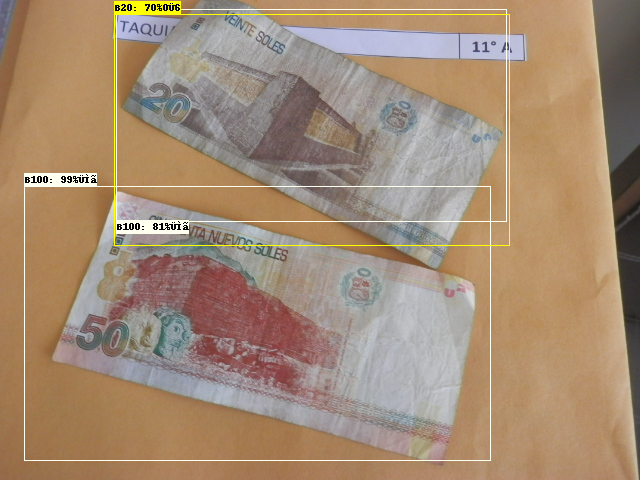

In [0]:
IMAGE_NAME = 'images/train/P8120089.JPG'

PATH_TO_IMAGE = os.path.join(CWD_PATH,IMAGE_NAME)
print(PATH_TO_IMAGE)

image = cv2.imread(PATH_TO_IMAGE)
image_expanded = np.expand_dims(image, axis=0)

(boxes, scores, classes, num) = sess.run(
    [detection_boxes, detection_scores, detection_classes, num_detections],
    feed_dict={image_tensor: image_expanded})

vis_util.visualize_boxes_and_labels_on_image_array(
    image,
    np.squeeze(boxes),
    np.squeeze(classes).astype(np.int32),
    np.squeeze(scores),
    category_index,
    use_normalized_coordinates=True,
    line_thickness=1,
    min_score_thresh=0.60)

from google.colab.patches import cv2_imshow
# cv2.imshow('Object detector', image)
cv2_imshow(image)

cv2.waitKey(0)

cv2.destroyAllWindows()

In [0]:
best_model_id = !ls training/model.ckpt-*.index -1t
best_model_id = best_model_id[0][20:-6]
print(best_model_id)
list_model = !ls  training/model.ckpt-{best_model_id}* -1
print(list_model)

116400
['training/model.ckpt-116400.data-00000-of-00001', 'training/model.ckpt-116400.index', 'training/model.ckpt-116400.meta']


In [0]:
import datetime

now = datetime.datetime.now()
zip_name = 'bills_model_{}_{}.zip'.format(best_model_id,now.strftime("%Y-%m-%d_%H:%M"))
!zip {zip_name} {' '.join(list_model)}
print("Success in %s Created" % zip_name)

  adding: training/model.ckpt-116400.data-00000-of-00001 (deflated 6%)
  adding: training/model.ckpt-116400.index (deflated 72%)
  adding: training/model.ckpt-116400.meta (deflated 94%)
Success in bills_model_116400_2019-09-18_15:02.zip Created


In [0]:
from google.colab import files
files.download(zip_name)

In [0]:
!pip install -q tf-nightly-2.0-preview
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [0]:
%tensorboard --logdir training/

In [0]:
from tensorboard import notebook
notebook.list()

Known TensorBoard instances:
  - port 6006: logdir training/ (started 0:06:45 ago; pid 5140)


In [0]:
notebook.display(port=6006, height=1000) 

In [0]:
!mv train_labels.csv images/
!mv test_labels.csv images/